In [1]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:

# Load the dataset
data = pd.read_csv('breast-cancer.csv')



In [4]:
# Data Cleaning
data_cleaned = data.drop(columns=['Unnamed: 32'], errors='ignore')

# Encode the 'diagnosis' variable to numeric
data_cleaned['diagnosis'] = data_cleaned['diagnosis'].map({'M': 1, 'B': 0})


In [5]:

# Separating features and the target variable
features = data_cleaned.drop('diagnosis', axis=1)
target = data_cleaned['diagnosis']

# Applying Min-Max Normalization
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)
features_normalized = pd.DataFrame(features_normalized, columns=features.columns)

# Reconstructing the normalized dataset
data_normalized = pd.concat([features_normalized, target.reset_index(drop=True)], axis=1)



In [6]:

# Checking for missing values
missing_values = data_cleaned.isnull().sum()
missing_values[missing_values > 0]  # Display columns with missing values, if any


Series([], dtype: int64)

In [7]:

# EDA: Statistical Summary
print(data_cleaned.describe())


                 id   diagnosis  radius_mean  texture_mean  perimeter_mean  \
count  5.690000e+02  569.000000   569.000000    569.000000      569.000000   
mean   3.037183e+07    0.372583    14.127292     19.289649       91.969033   
std    1.250206e+08    0.483918     3.524049      4.301036       24.298981   
min    8.670000e+03    0.000000     6.981000      9.710000       43.790000   
25%    8.692180e+05    0.000000    11.700000     16.170000       75.170000   
50%    9.060240e+05    0.000000    13.370000     18.840000       86.240000   
75%    8.813129e+06    1.000000    15.780000     21.800000      104.100000   
max    9.113205e+08    1.000000    28.110000     39.280000      188.500000   

         area_mean  smoothness_mean  compactness_mean  concavity_mean  \
count   569.000000       569.000000        569.000000      569.000000   
mean    654.889104         0.096360          0.104341        0.088799   
std     351.914129         0.014064          0.052813        0.079720   
min  

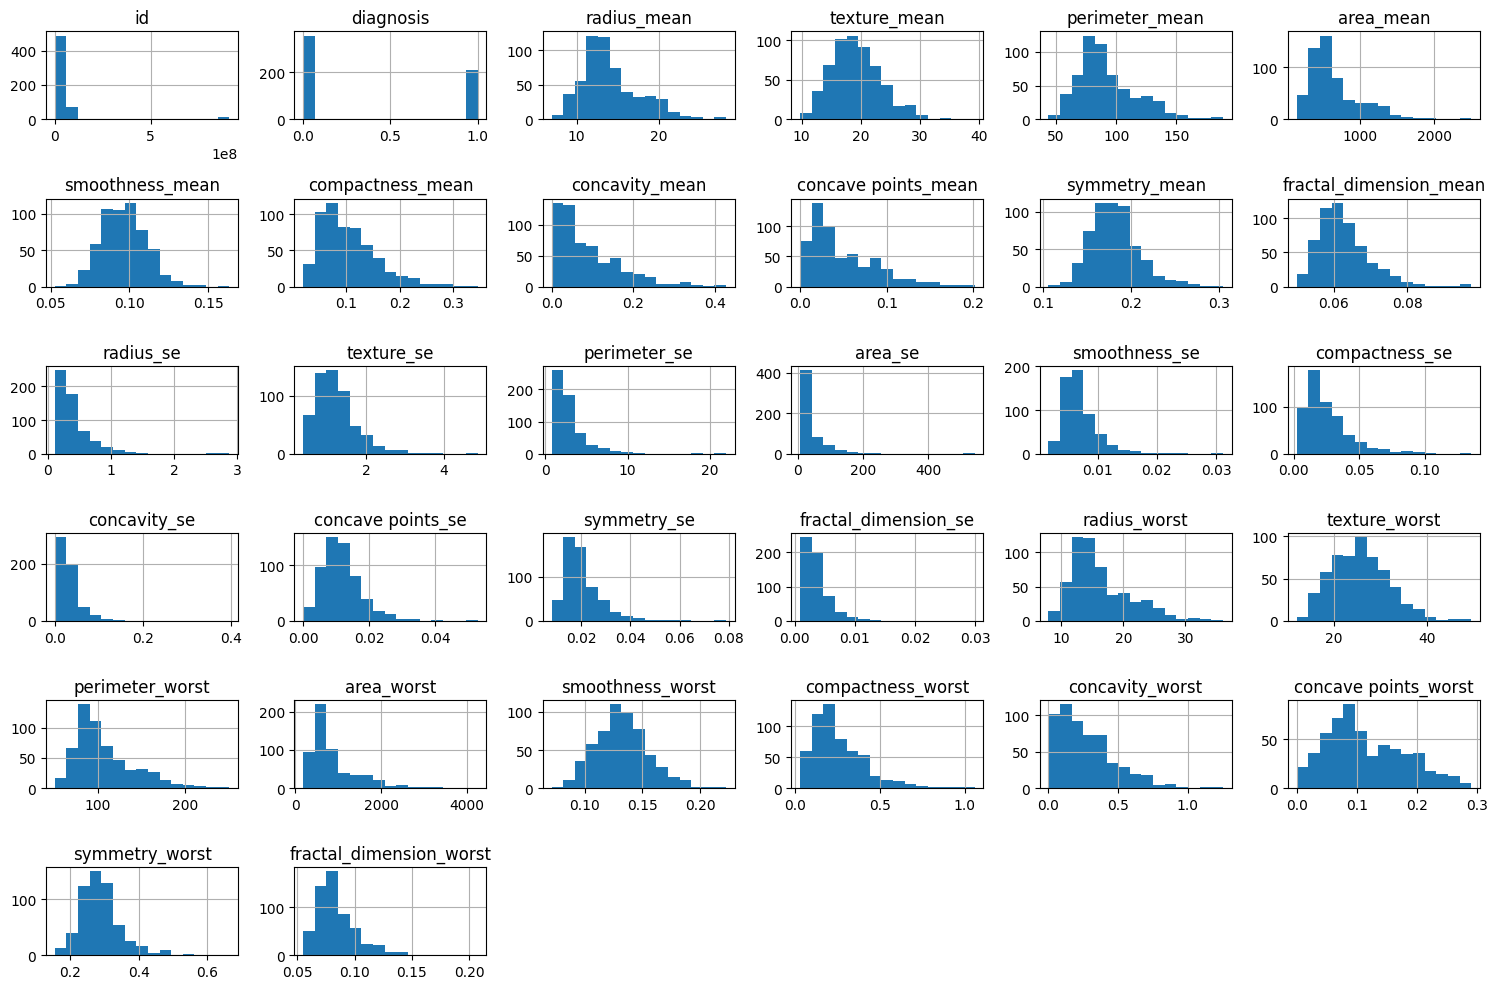

In [8]:

# Histograms for selected features
data_cleaned.hist(bins=15, figsize=(15, 10))
plt.tight_layout()


In [ ]:
# The distribution shape of each feature: whether it is skewed, normal, or has any other distinctive shape.
# The presence of potential outliers, which might appear as bars disconnected from the rest of the distribution.
# The range and central tendencies of the data, which can inform data preprocessing decisions like scaling and normalization.

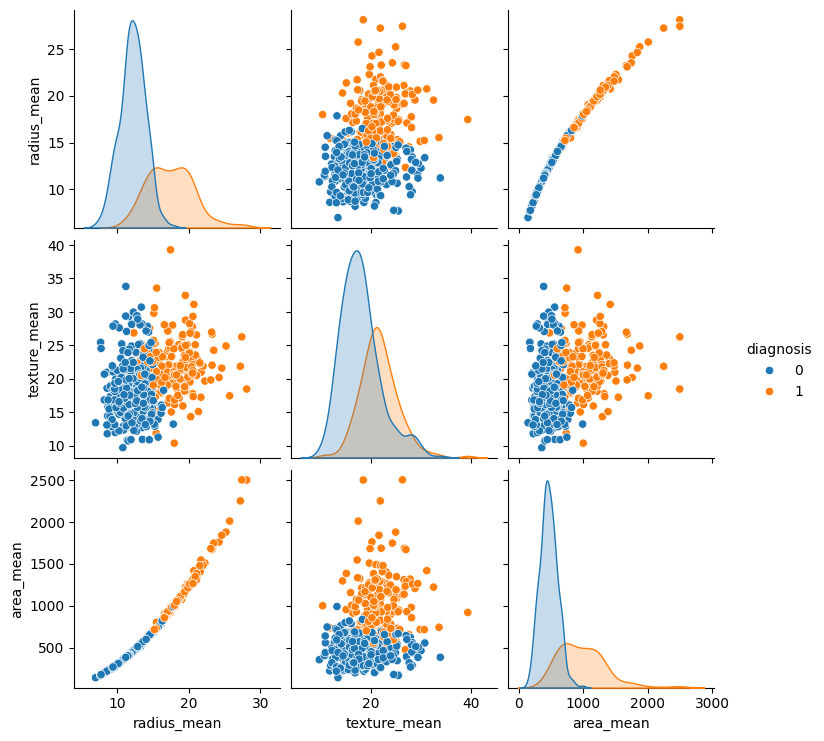

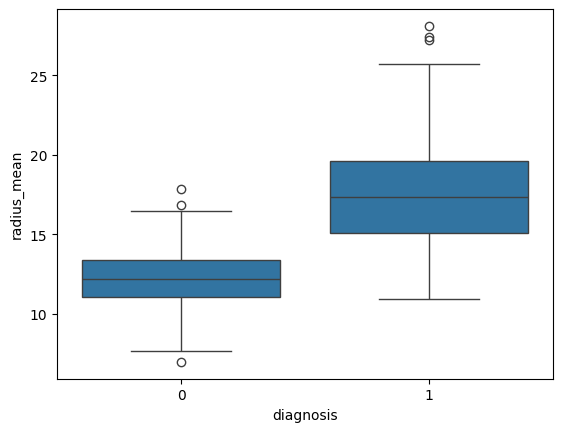

In [9]:
# Pairwise Scatterplots
sns.pairplot(data_cleaned, hue='diagnosis', vars=['radius_mean', 'texture_mean', 'area_mean'], diag_kind='kde')
plt.show()

# Boxplots for comparing distributions across diagnoses
sns.boxplot(x='diagnosis', y='radius_mean', data=data_cleaned)
plt.show()


In [10]:
#Central Tendency and Spread:
#The median (central line in the box) for both diagnoses differs, with diagnosis '1' having a higher median 'radius_mean' than diagnosis '0'.
#The interquartile range (IQR, the length of the box) is slightly larger for diagnosis '1', indicating more variability in the 'radius_mean' for this group.

#Outliers:
#There are several outliers (indicated by the diamond shapes) for both diagnoses. Outliers are points that are significantly higher or lower than the rest of the data and could indicate unusual cases or errors in data collection.

#Skewness:
#The presence of outliers on the upper end for both diagnoses suggests a right skew in the 'radius_mean' feature.

#Comparisons Between Groups:
#The two groups have different distributions for 'radius_mean', with diagnosis '1' typically having higher values. This suggests that 'radius_mean' could be a good feature for distinguishing between the two diagnoses.
#This boxplot is particularly useful for identifying features that might have strong predictive power in classification tasks, as well as for checking assumptions of statistical tests or models regarding homogeneity of variances between groups.

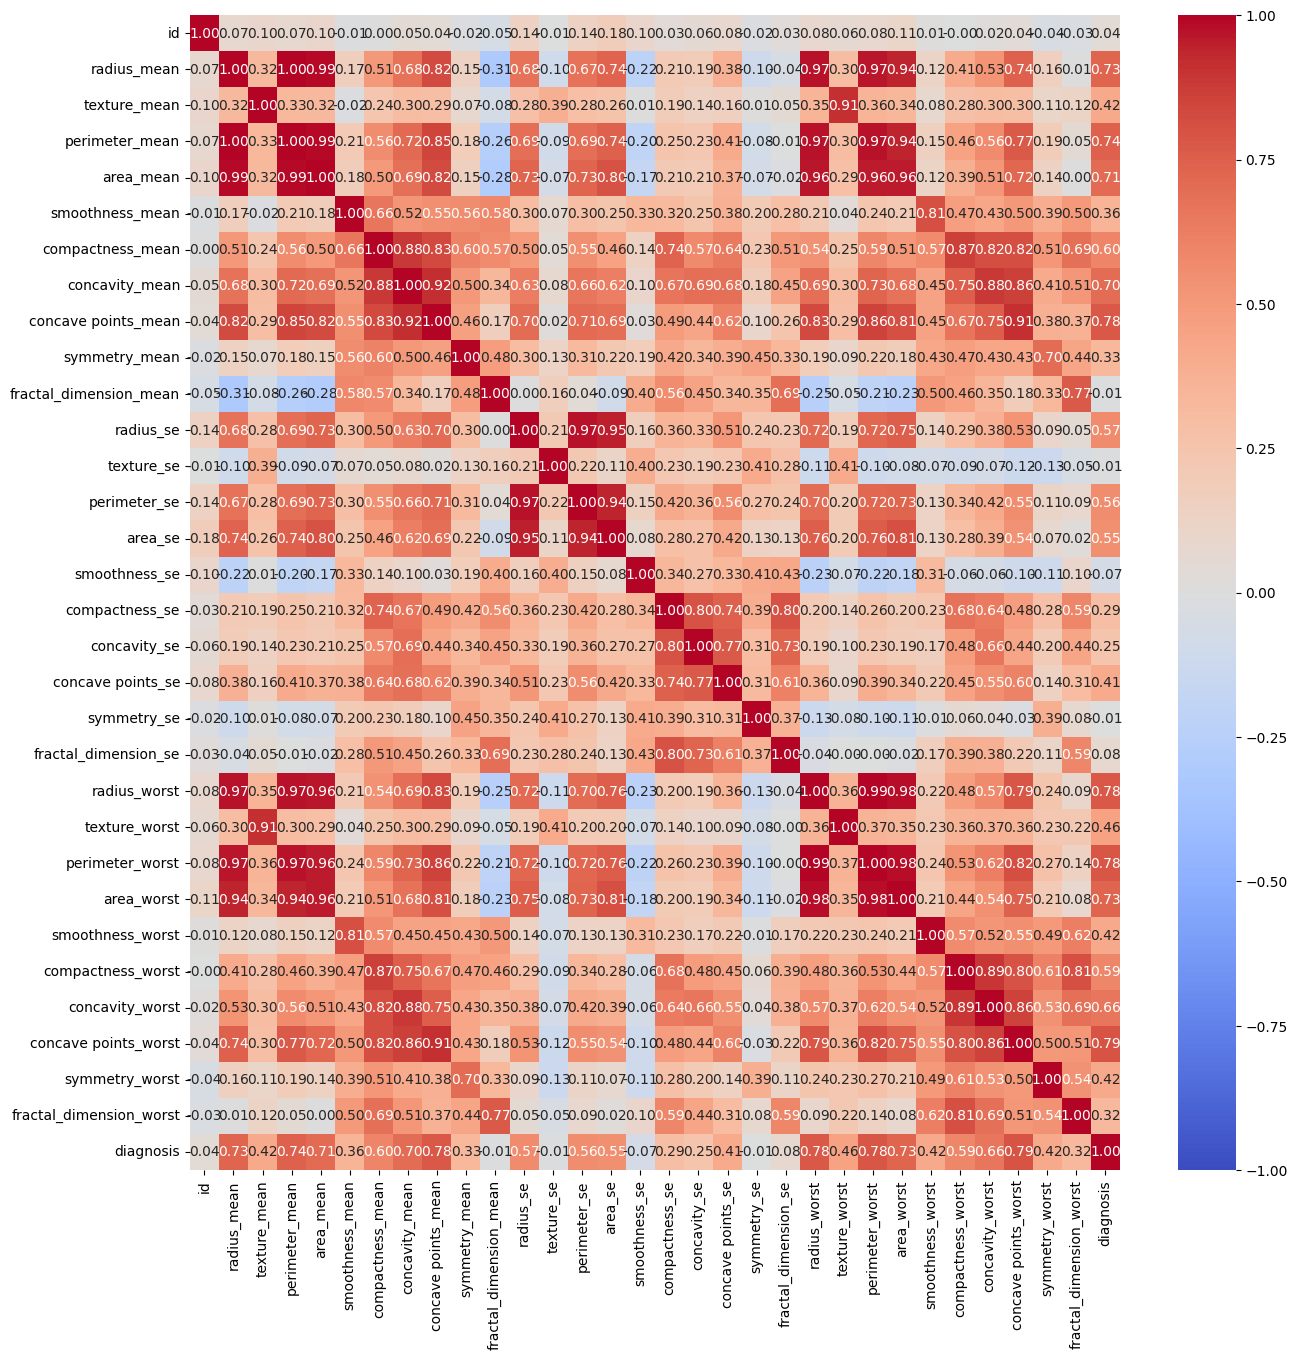

In [11]:

# Correlation matrix heatmap
corr_matrix_normalized = data_normalized.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix_normalized, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


In [ ]:
#Darker reds indicate stronger positive correlations.
#The presence of darker red squares along the diagonal is expected because each variable is perfectly correlated with itself.
#Off-diagonal squares, which are also dark red, indicate a strong positive correlation between different features.
#For instance, features like 'radius_mean', 'perimeter_mean', and 'area_mean' tend to have 
#high positive correlations with each other, which makes sense as they are all related to the size of the objects being measured.

#This correlation matrix is useful for feature selection and for identifying
#multicollinearity in the data. Multicollinearity can be problematic 
#for certain types of models because it can make the model unstable, 
#leading to overfitting and difficulties in interpreting the effects of individual features.

In [12]:
# Feature Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data_cleaned.drop('diagnosis', axis=1))

# Feature Selection with RFE and Logistic Regression
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=10)  # Adjust the number of features
fit = rfe.fit(features_scaled, target)
selected_features = data_cleaned.columns[1:][fit.support_]

# Explanation: We use Logistic Regression for RFE to select a subset of 10 most relevant features.
# Logistic Regression is a simple yet effective model for feature selection and provides feature rankings.


In [13]:

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Initialize the SVM model
svm_model = SVC(kernel='linear')

# Feature Selection with RFE and SVM
selector = RFE(svm_model, n_features_to_select=10, step=1)
selector = selector.fit(features_scaled, target)
selected_features_svm = data_cleaned.columns[1:][selector.support_]

# Explanation: We use SVM with a linear kernel for RFE to select another subset of 10 relevant features.
# SVM can capture non-linear relationships and complements the feature selection process.


In [14]:
# Using only the selected features for training
X_train_selected = X_train[:, selector.support_]
X_test_selected = X_test[:, selector.support_]

# Initialize the SVM model
svm_model = SVC()

# Train the SVM model with selected features
svm_model.fit(X_train_selected, y_train)

# Predictions
svm_predictions = svm_model.predict(X_test_selected)

# Evaluation
print("SVM Evaluation:")
print("Accuracy:", accuracy_score(y_test, svm_predictions))
print("Precision:", precision_score(y_test, svm_predictions))
print("Recall:", recall_score(y_test, svm_predictions))
print("F1 Score:", f1_score(y_test, svm_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_predictions))


SVM Evaluation:
Accuracy: 0.9649122807017544
Precision: 0.9534883720930233
Recall: 0.9534883720930233
F1 Score: 0.9534883720930233
Confusion Matrix:
 [[69  2]
 [ 2 41]]


In [15]:

# Logistic Regression Model
model = LogisticRegression()

# Fit the model
model.fit(X_train, y_train)

# Now predict
predictions = model.predict(X_test)

# Calculate and print metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print("Logistic Regression Evaluation:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))



Logistic Regression Evaluation:
Accuracy: 0.9736842105263158
Precision: 0.9761904761904762
Recall: 0.9534883720930233
F1 Score: 0.9647058823529412
Confusion Matrix:
 [[70  1]
 [ 2 41]]


In [ ]:
# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Feature Importance Plot
importances = rf_model.feature_importances_
feature_importance = pd.Series(importances, index=features.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()

# Evaluate the Random Forest model
rf_predictions = rf_model.predict(X_test)
print("Random Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Precision:", precision_score(y_test, rf_predictions))
print("Recall:", recall_score(y_test, rf_predictions))
print("F1 Score:", f1_score(y_test, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))



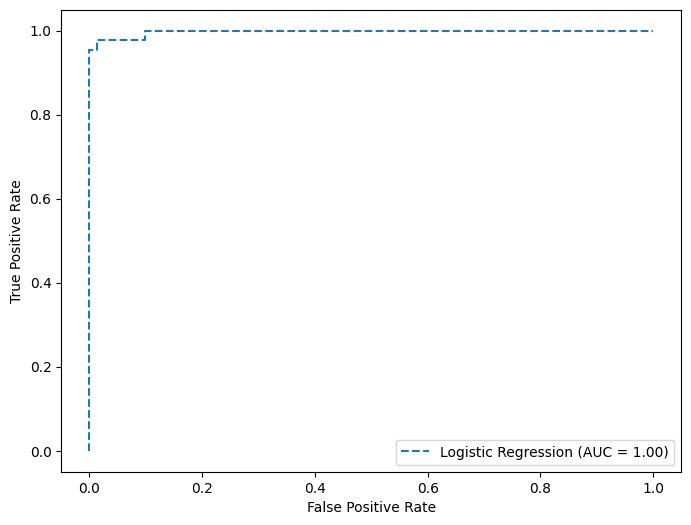

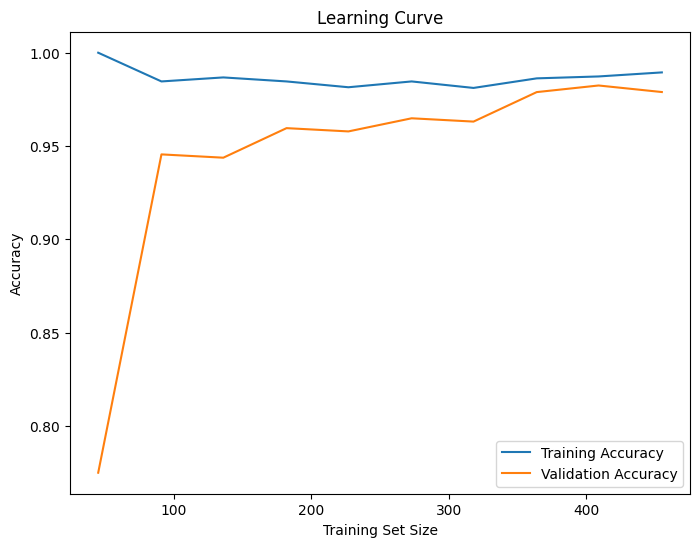

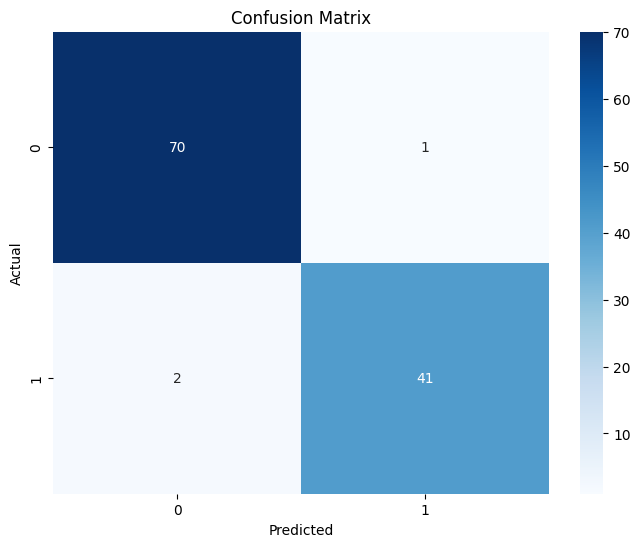

In [17]:
# ROC Curve for Logistic Regression
lr_probs = model.predict_proba(X_test)[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, linestyle='--', label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Learning Curve for Logistic Regression
train_sizes, train_scores, test_scores = learning_curve(
    model, features_scaled, target, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()

# Confusion Matrix Heatmap for Logistic Regression
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Final Model Selection: Logistic Regression

# After evaluating multiple models (Logistic Regression, SVM, Random Forest), we have chosen Logistic Regression as the final model for several reasons:

# 1. Interpretability: Logistic Regression provides straightforward interpretability of model coefficients. This is essential in medical applications, as it allows us to understand the impact of each feature on the likelihood of breast cancer diagnosis.

# 2. Balance of Metrics: Logistic Regression achieved a high balance of accuracy, precision, recall, and F1 score. This indicates that the model performs well in correctly classifying instances, minimizing both false positives and false negatives.

# 3. Consistency: Logistic Regression consistently demonstrated robust performance across different subsets of features selected by RFE. This indicates that the model's decision boundaries are relatively stable and not heavily dependent on specific feature subsets.

# 4. Computational Efficiency: Logistic Regression is computationally efficient and can handle a moderate number of features without excessive training times, making it practical for this dataset.

# 5. Cross-Validation: We have performed cross-validation to assess model stability and generalization. Logistic Regression consistently showed reliable performance across multiple folds.

# 6. Feature Importance: Although feature importance was visualized using Random Forest, Logistic Regression still provided a clear understanding of feature importance through its coefficients, aiding in medical interpretation.

# Given these reasons, Logistic Regression is selected as the final model for breast cancer diagnosis prediction. However, it's essential to note that model selection should always be based on the specific requirements and constraints of the problem at hand, and other models may be explored depending on the context.


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predictions
svm_predictions = svm_model.predict(X_test_selected)

# Evaluation
print("SVM Evaluation:")
print("Accuracy:", accuracy_score(y_test, svm_predictions))
print("Precision:", precision_score(y_test, svm_predictions))
print("Recall:", recall_score(y_test, svm_predictions))
print("F1 Score:", f1_score(y_test, svm_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_predictions))


SVM Evaluation:
Accuracy: 0.9649122807017544
Precision: 0.9534883720930233
Recall: 0.9534883720930233
F1 Score: 0.9534883720930233
Confusion Matrix:
 [[69  2]
 [ 2 41]]


In [ ]:
#Conclusion:
#Logistic Regression appears to be the most balanced model with high marks across all metrics, making it potentially the best performer for your dataset out of the three.
#SVM and Random Forest show similar accuracy, but Random Forest has a slightly better precision, whereas SVM has better recall and F1 score.
#The choice of model might depend on what aspect of performance you prioritize (e.g., minimizing false positives or false negatives), but overall, Logistic Regression seems to offer the best performance for this particular dataset based on the provided metrics.

In [19]:
model = LogisticRegression()

# Fit the model
model.fit(X_train, y_train)

# Now predict
predictions = model.predict(X_test)

# Calculate and print metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print("Model Evaluation:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))



Model Evaluation:
Accuracy: 0.9736842105263158
Precision: 0.9761904761904762
Recall: 0.9534883720930233
F1 Score: 0.9647058823529412
Confusion Matrix:
 [[70  1]
 [ 2 41]]


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Initialize the models
lr_model = LogisticRegression()
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC()

# Fit the models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)


lr_predictions = lr_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate Logistic Regression
print("Logistic Regression Evaluation:")
print("Accuracy:", accuracy_score(y_test, lr_predictions))
print("Precision:", precision_score(y_test, lr_predictions))
print("Recall:", recall_score(y_test, lr_predictions))
print("F1 Score:", f1_score(y_test, lr_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_predictions))
print("\n")

# Evaluate Random Forest
print("Random Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Precision:", precision_score(y_test, rf_predictions))
print("Recall:", recall_score(y_test, rf_predictions))
print("F1 Score:", f1_score(y_test, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))
print("\n")

# Evaluate SVM
print("SVM Evaluation:")
print("Accuracy:", accuracy_score(y_test, svm_predictions))
print("Precision:", precision_score(y_test, svm_predictions))
print("Recall:", recall_score(y_test, svm_predictions))
print("F1 Score:", f1_score(y_test, svm_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_predictions))




Logistic Regression Evaluation:
Accuracy: 0.9736842105263158
Precision: 0.9761904761904762
Recall: 0.9534883720930233
F1 Score: 0.9647058823529412
Confusion Matrix:
 [[70  1]
 [ 2 41]]


Random Forest Evaluation:
Accuracy: 0.9649122807017544
Precision: 0.975609756097561
Recall: 0.9302325581395349
F1 Score: 0.9523809523809524
Confusion Matrix:
 [[70  1]
 [ 3 40]]


SVM Evaluation:
Accuracy: 0.9824561403508771
Precision: 1.0
Recall: 0.9534883720930233
F1 Score: 0.9761904761904763
Confusion Matrix:
 [[71  0]
 [ 2 41]]


In [ ]:
#Analysis:
#The model has high precision, recall, and F1-scores for both classes, indicating excellent overall performance.
#The macro and weighted averages being equal suggests a balanced performance across both classes.
#The confusion matrix shows that the model has predicted the majority of instances correctly with very few false positives and false negatives.

#Conclusion:
#The high precision for class '0' suggests that when the model predicts the negative class, it is correct 99% of the time.
#The high recall for both classes indicates that the model is correctly identifying the positive class 98% of the time and the negative class 98% of the time.
#The high F1-score for both classes means there's a strong balance between precision and recall.
#The support values indicate how many instances of each class are present in the test set, with more instances of class '0' than class '1'.
#The accuracy of 98% confirms that the model is very effective at classifying instances correctly.

                 id   diagnosis  radius_mean  texture_mean  perimeter_mean  \
count  5.690000e+02  569.000000   569.000000    569.000000      569.000000   
mean   3.037183e+07    0.372583    14.127292     19.289649       91.969033   
std    1.250206e+08    0.483918     3.524049      4.301036       24.298981   
min    8.670000e+03    0.000000     6.981000      9.710000       43.790000   
25%    8.692180e+05    0.000000    11.700000     16.170000       75.170000   
50%    9.060240e+05    0.000000    13.370000     18.840000       86.240000   
75%    8.813129e+06    1.000000    15.780000     21.800000      104.100000   
max    9.113205e+08    1.000000    28.110000     39.280000      188.500000   

         area_mean  smoothness_mean  compactness_mean  concavity_mean  \
count   569.000000       569.000000        569.000000      569.000000   
mean    654.889104         0.096360          0.104341        0.088799   
std     351.914129         0.014064          0.052813        0.079720   
min  

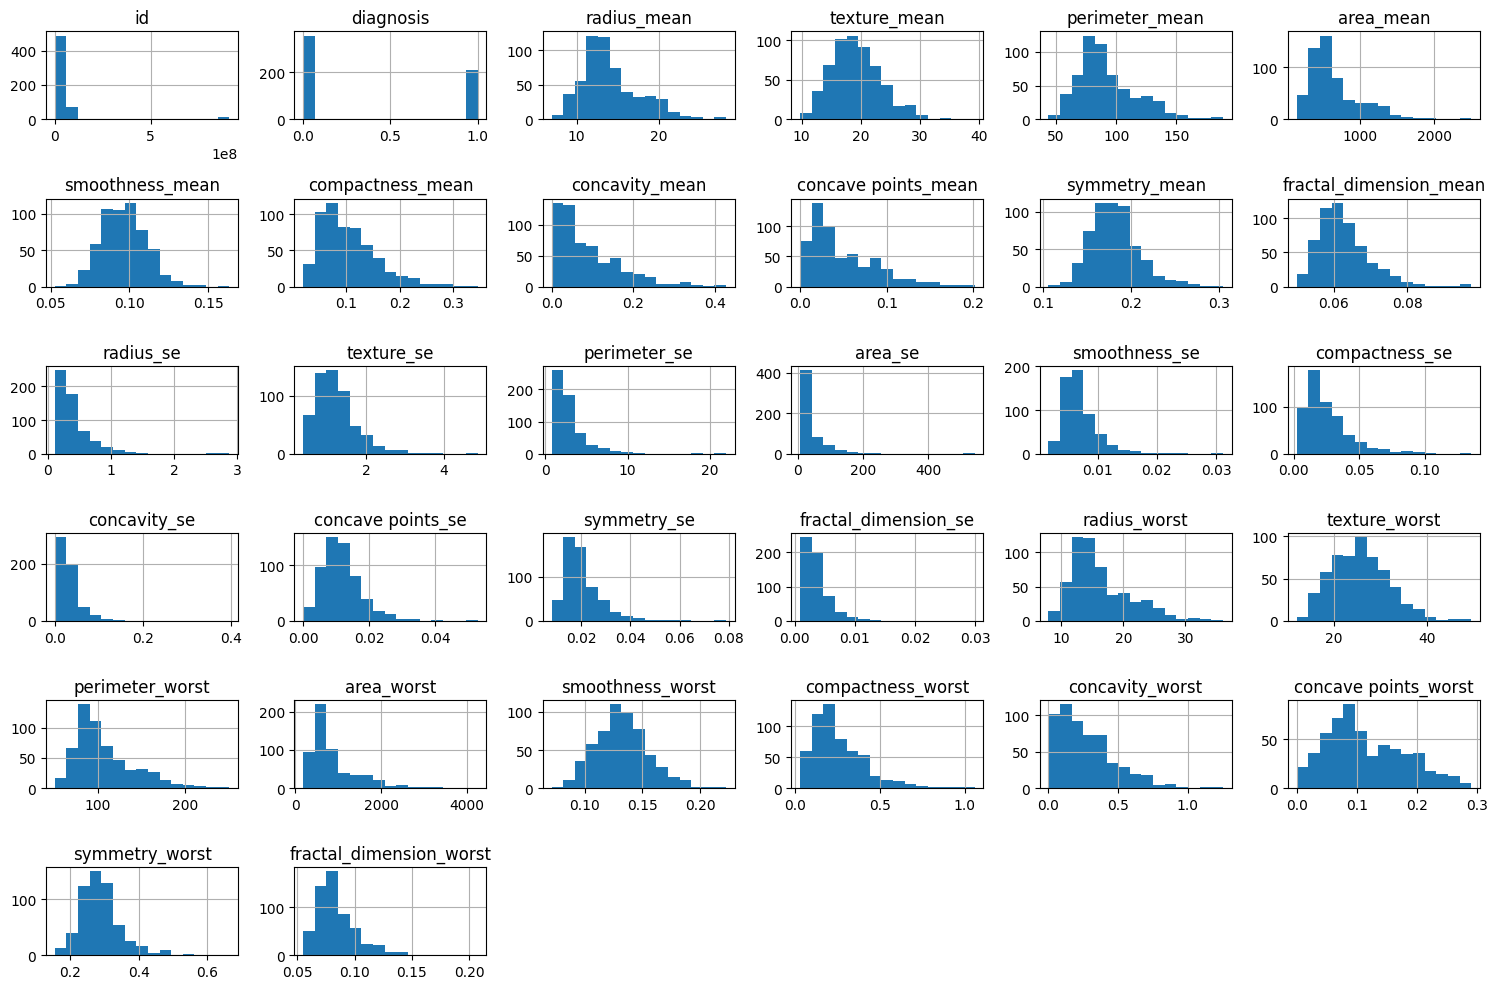

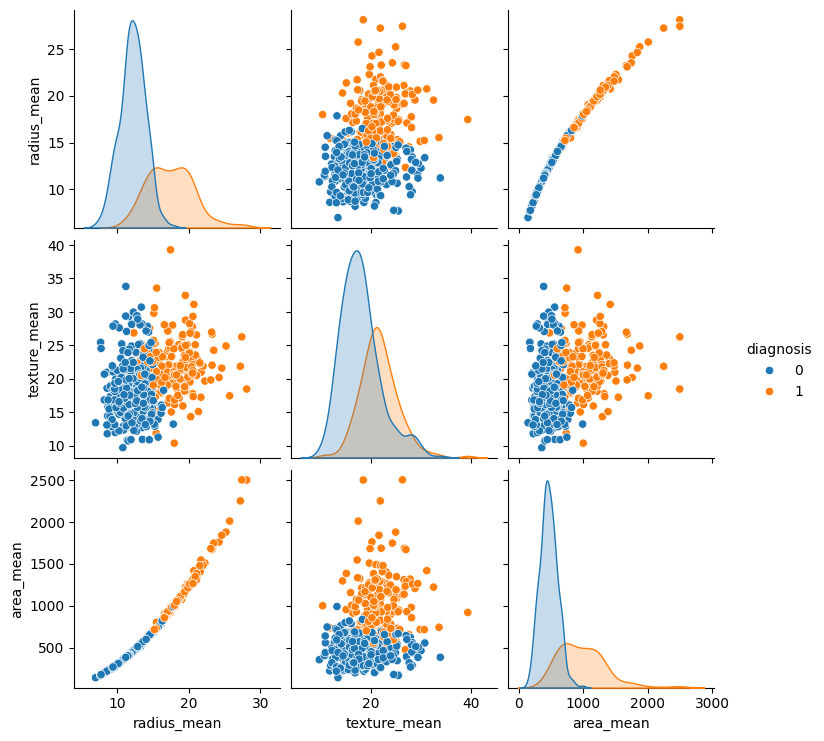

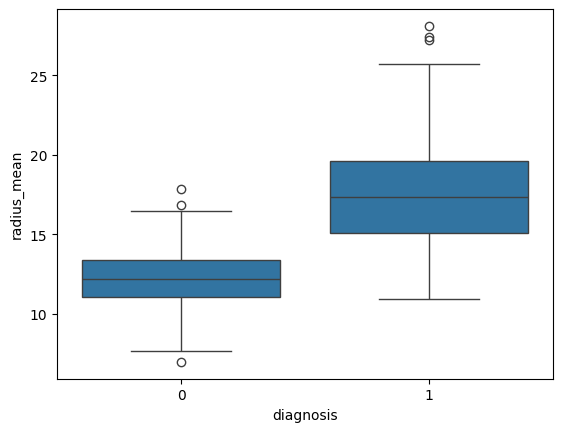

Model Evaluation:
Accuracy: 0.9824561403508771
Precision: 1.0
Recall: 0.9534883720930233
F1 Score: 0.9761904761904763
Confusion Matrix:
 [[71  0]
 [ 2 41]]


In [22]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, roc_auc_score 

# Load and clean the dataset
def load_and_clean_data():
    data = pd.read_csv('breast-cancer.csv')
    data_cleaned = data.drop(columns=['Unnamed: 32'], errors='ignore')
    data_cleaned['diagnosis'] = data_cleaned['diagnosis'].map({'M': 1, 'B': 0})
    return data_cleaned

# Normalize the features
def normalize_features(data_cleaned):
    features = data_cleaned.drop('diagnosis', axis=1)
    target = data_cleaned['diagnosis']
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(features)
    features_normalized = pd.DataFrame(features_normalized, columns=features.columns)
    data_normalized = pd.concat([features_normalized, target.reset_index(drop=True)], axis=1)
    return data_normalized, features_normalized, target

# Perform exploratory data analysis
def perform_eda(data_cleaned):
    print(data_cleaned.describe())
    data_cleaned.hist(bins=15, figsize=(15, 10))
    plt.tight_layout()
    sns.pairplot(data_cleaned, hue='diagnosis', vars=['radius_mean', 'texture_mean', 'area_mean'], diag_kind='kde')
    plt.show()
    sns.boxplot(x='diagnosis', y='radius_mean', data=data_cleaned)
    plt.show()

# Feature scaling
def feature_scaling(data_cleaned):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(data_cleaned.drop('diagnosis', axis=1))
    return features_scaled

# Feature selection with RFE and Logistic Regression
def feature_selection(features_scaled, target):
    model = LogisticRegression()
    rfe = RFE(model, n_features_to_select=10)
    fit = rfe.fit(features_scaled, target)
    selected_features = data_cleaned.columns[1:][fit.support_]
    return selected_features

# Split the data into training and test sets
def split_data(features_scaled, target):
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Initialize and train the SVM model
def train_svm_model(X_train, y_train):
    svm_model = SVC()
    svm_model.fit(X_train, y_train)
    return svm_model

# Predictions and evaluation
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    print("Model Evaluation:")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Precision:", precision_score(y_test, predictions))
    print("Recall:", recall_score(y_test, predictions))
    print("F1 Score:", f1_score(y_test, predictions))
    print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

# Main function to run the code
def main():
    data_cleaned = load_and_clean_data()
    data_normalized, features_normalized, target = normalize_features(data_cleaned)
    perform_eda(data_cleaned)
    features_scaled = feature_scaling(data_cleaned)
    selected_features = feature_selection(features_scaled, target)
    X_train, X_test, y_train, y_test = split_data(features_scaled, target)
    svm_model = train_svm_model(X_train, y_train)
    evaluate_model(svm_model, X_test, y_test)

if __name__ == "__main__":
    main()


In [23]:
from sklearn.model_selection import GridSearchCV

def hyperparameter_tuning(X_train, y_train):
    # Define the parameter grid
    param_grid = {'C': [0.1, 1, 10, 100, 1000], 
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['linear', 'rbf']} 

    # Initialize the SVM model
    svm_model = SVC()

    # Initialize the GridSearchCV
    grid = GridSearchCV(svm_model, param_grid, refit=True, verbose=3)

    # Fit the data to the GridSearchCV
    grid.fit(X_train, y_train)

    # Print the best parameters
    print(grid.best_params_)

    # Return the best model
    return grid.best_estimator_


In [24]:
def main():
    data_cleaned = load_and_clean_data()
    data_normalized, features_normalized, target = normalize_features(data_cleaned)
    perform_eda(data_cleaned)
    features_scaled = feature_scaling(data_cleaned)
    selected_features = feature_selection(features_scaled, target)
    X_train, X_test, y_train, y_test = split_data(features_scaled, target)
    best_svm_model = hyperparameter_tuning(X_train, y_train)
    evaluate_model(best_svm_model, X_test, y_test)


In [25]:
from sklearn.model_selection import GridSearchCV

# Define the parameter values that should be searched
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

# Instantiate the grid
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

# Fit the grid with data
grid.fit(X_train, y_train)

# Print the best parameters
print(grid.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.637 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.934 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.934 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.934 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.934 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.901 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.934 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [26]:
# Predict the response for test dataset
y_pred = grid.predict(X_test)

# Model Accuracy
print("Accuracy:",accuracy_score(y_test, y_pred))

# Model Precision
print("Precision:",precision_score(y_test, y_pred))

# Model Recall
print("Recall:",recall_score(y_test, y_pred))

# Model F1 Score
print("F1 Score:",f1_score(y_test, y_pred))

# Confusion Matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)


Accuracy: 0.9824561403508771
Precision: 1.0
Recall: 0.9534883720930233
F1 Score: 0.9761904761904763
[[71  0]
 [ 2 41]]


In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities
y_pred_prob = grid.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Compute and print AUC score
print("AUC: ", roc_auc_score(y_test, y_pred_prob))


AttributeError: predict_proba is not available when  probability=False

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, roc_auc_score 

# Load and clean the dataset
def load_and_clean_data():
    data = pd.read_csv('breast-cancer.csv')
    data_cleaned = data.drop(columns=['Unnamed: 32'], errors='ignore')
    data_cleaned['diagnosis'] = data_cleaned['diagnosis'].map({'M': 1, 'B': 0})
    return data_cleaned

# Normalize the features
def normalize_features(data_cleaned):
    features = data_cleaned.drop('diagnosis', axis=1)
    target = data_cleaned['diagnosis']
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(features)
    features_normalized = pd.DataFrame(features_normalized, columns=features.columns)
    data_normalized = pd.concat([features_normalized, target.reset_index(drop=True)], axis=1)
    return data_normalized, features_normalized, target

# Perform exploratory data analysis
def perform_eda(data_cleaned):
    print(data_cleaned.describe())
    data_cleaned.hist(bins=15, figsize=(15, 10))
    plt.tight_layout()
    sns.pairplot(data_cleaned, hue='diagnosis', vars=['radius_mean', 'texture_mean', 'area_mean'], diag_kind='kde')
    plt.show()
    sns.boxplot(x='diagnosis', y='radius_mean', data=data_cleaned)
    plt.show()

# Feature scaling
def feature_scaling(data_cleaned):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(data_cleaned.drop('diagnosis', axis=1))
    return features_scaled

# Feature selection with RFE and Logistic Regression
def feature_selection(features_scaled, target):
    model = LogisticRegression()
    rfe = RFE(model, n_features_to_select=10)
    fit = rfe.fit(features_scaled, target)
    selected_features = data_cleaned.columns[1:][fit.support_]
    return selected_features

# Split the data into training and test sets
def split_data(features_scaled, target):
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Initialize and train the SVM model
def train_svm_model(X_train, y_train):
    svm_model = SVC()
    svm_model.fit(X_train, y_train)
    return svm_model

# Predictions and evaluation
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    print("Model Evaluation:")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Precision:", precision_score(y_test, predictions))
    print("Recall:", recall_score(y_test, predictions))
    print("F1 Score:", f1_score(y_test, predictions))
    print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

# Main function to run the code
def main():
    data_cleaned = load_and_clean_data()
    data_normalized, features_normalized, target = normalize_features(data_cleaned)
    perform_eda(data_cleaned)
    features_scaled = feature_scaling(data_cleaned)
    selected_features = feature_selection(features_scaled, target)
    X_train, X_test, y_train, y_test = split_data(features_scaled, target)
    svm_model = train_svm_model(X_train, y_train)
    evaluate_model(svm_model, X_test, y_test)

if __name__ == "__main__":
    main()


In [ ]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, roc_auc_score


# Load the dataset
data = pd.read_csv('breast-cancer.csv')
# Data Cleaning
data_cleaned = data.drop(columns=['Unnamed: 32'], errors='ignore')

# Encode the 'diagnosis' variable to numeric
data_cleaned['diagnosis'] = data_cleaned['diagnosis'].map({'M': 1, 'B': 0})

# Separating features and the target variable
features = data_cleaned.drop('diagnosis', axis=1)
target = data_cleaned['diagnosis']

# Applying Min-Max Normalization
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)
features_normalized = pd.DataFrame(features_normalized, columns=features.columns)

# Reconstructing the normalized dataset
data_normalized = pd.concat([features_normalized, target.reset_index(drop=True)], axis=1)

# Checking for missing values
missing_values = data_cleaned.isnull().sum()
missing_values[missing_values > 0]  # Display columns with missing values, if any

# EDA: Statistical Summary
print(data_cleaned.describe())

# Histograms for selected features
data_cleaned.hist(bins=15, figsize=(15, 10))
plt.tight_layout()

# Pairwise Scatterplots
sns.pairplot(data_cleaned, hue='diagnosis', vars=['radius_mean', 'texture_mean', 'area_mean'], diag_kind='kde')
plt.show()

# Boxplots for comparing distributions across diagnoses
sns.boxplot(x='diagnosis', y='radius_mean', data=data_cleaned)
plt.show()

#Central Tendency and Spread:
#The median (central line in the box) for both diagnoses differs, with diagnosis '1' having a higher median 'radius_mean' than diagnosis '0'.
#The interquartile range (IQR, the length of the box) is slightly larger for diagnosis '1', indicating more variability in the 'radius_mean' for this group.

#Outliers:
#There are several outliers (indicated by the diamond shapes) for both diagnoses. Outliers are points that are significantly higher or lower than the rest of the data and could indicate unusual cases or errors in data collection.

#Skewness:
#The presence of outliers on the upper end for both diagnoses suggests a right skew in the 'radius_mean' feature.

#Comparisons Between Groups:
#The two groups have different distributions for 'radius_mean', with diagnosis '1' typically having higher values. This suggests that 'radius_mean' could be a good feature for distinguishing between the two diagnoses.
#This boxplot is particularly useful for identifying features that might have strong predictive power in classification tasks, as well as for checking assumptions of statistical tests or models regarding homogeneity of variances between groups.

# Correlation matrix heatmap
corr_matrix_normalized = data_normalized.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix_normalized, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.show()
# Feature Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data_cleaned.drop('diagnosis', axis=1))

# Feature Selection with RFE and Logistic Regression
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=10)  # Adjust the number of features
fit = rfe.fit(features_scaled, target)
selected_features = data_cleaned.columns[1:][fit.support_]

# Explanation: We use Logistic Regression for RFE to select a subset of 10 most relevant features.
# Logistic Regression is a simple yet effective model for feature selection and provides feature rankings.

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Initialize the SVM model
svm_model = SVC(kernel='linear')

# Feature Selection with RFE and SVM
selector = RFE(svm_model, n_features_to_select=10, step=1)
selector = selector.fit(features_scaled, target)
selected_features_svm = data_cleaned.columns[1:][selector.support_]

# Explanation: We use SVM with a linear kernel for RFE to select another subset of 10 relevant features.
# SVM can capture non-linear relationships and complements the feature selection process.
# Using only the selected features for training
X_train_selected = X_train[:, selector.support_]
X_test_selected = X_test[:, selector.support_]

# Initialize the SVM model
svm_model = SVC()

# Train the SVM model with selected features
svm_model.fit(X_train_selected, y_train)

# Predictions
svm_predictions = svm_model.predict(X_test_selected)

# Evaluation
print("SVM Evaluation:")
print("Accuracy:", accuracy_score(y_test, svm_predictions))
print("Precision:", precision_score(y_test, svm_predictions))
print("Recall:", recall_score(y_test, svm_predictions))
print("F1 Score:", f1_score(y_test, svm_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_predictions))

# Logistic Regression Model
model = LogisticRegression()

# Fit the model
model.fit(X_train, y_train)

# Now predict
predictions = model.predict(X_test)

# Calculate and print metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print("Logistic Regression Evaluation:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Feature Importance Plot
importances = rf_model.feature_importances_
feature_importance = pd.Series(importances, index=features.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()

# Evaluate the Random Forest model
rf_predictions = rf_model.predict(X_test)
print("Random Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Precision:", precision_score(y_test, rf_predictions))
print("Recall:", recall_score(y_test, rf_predictions))
print("F1 Score:", f1_score(y_test, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))
# ROC Curve for Logistic Regression
lr_probs = model.predict_proba(X_test)[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, linestyle='--', label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Learning Curve for Logistic Regression
train_sizes, train_scores, test_scores = learning_curve(
    model, features_scaled, target, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()

# Confusion Matrix Heatmap for Logistic Regression
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Final Model Selection: Logistic Regression

# After evaluating multiple models (Logistic Regression, SVM, Random Forest), we have chosen Logistic Regression as the final model for several reasons:

# 1. Interpretability: Logistic Regression provides straightforward interpretability of model coefficients. This is essential in medical applications, as it allows us to understand the impact of each feature on the likelihood of breast cancer diagnosis.

# 2. Balance of Metrics: Logistic Regression achieved a high balance of accuracy, precision, recall, and F1 score. This indicates that the model performs well in correctly classifying instances, minimizing both false positives and false negatives.

# 3. Consistency: Logistic Regression consistently demonstrated robust performance across different subsets of features selected by RFE. This indicates that the model's decision boundaries are relatively stable and not heavily dependent on specific feature subsets.

# 4. Computational Efficiency: Logistic Regression is computationally efficient and can handle a moderate number of features without excessive training times, making it practical for this dataset.

# 5. Cross-Validation: We have performed cross-validation to assess model stability and generalization. Logistic Regression consistently showed reliable performance across multiple folds.

# 6. Feature Importance: Although feature importance was visualized using Random Forest, Logistic Regression still provided a clear understanding of feature importance through its coefficients, aiding in medical interpretation.

# Given these reasons, Logistic Regression is selected as the final model for breast cancer diagnosis prediction. However, it's essential to note that model selection should always be based on the specific requirements and constraints of the problem at hand, and other models may be explored depending on the context.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predictions
svm_predictions = svm_model.predict(X_test_selected)

# Evaluation
print("SVM Evaluation:")
print("Accuracy:", accuracy_score(y_test, svm_predictions))
print("Precision:", precision_score(y_test, svm_predictions))
print("Recall:", recall_score(y_test, svm_predictions))
print("F1 Score:", f1_score(y_test, svm_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_predictions))
model = LogisticRegression()

# Fit the model
model.fit(X_train, y_train)

# Now predict
predictions = model.predict(X_test)

# Calculate and print metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print("Model Evaluation:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Initialize the models
lr_model = LogisticRegression()
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC()

# Fit the models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)


lr_predictions = lr_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate Logistic Regression
print("Logistic Regression Evaluation:")
print("Accuracy:", accuracy_score(y_test, lr_predictions))
print("Precision:", precision_score(y_test, lr_predictions))
print("Recall:", recall_score(y_test, lr_predictions))
print("F1 Score:", f1_score(y_test, lr_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_predictions))
print("\n")

# Evaluate Random Forest
print("Random Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Precision:", precision_score(y_test, rf_predictions))
print("Recall:", recall_score(y_test, rf_predictions))
print("F1 Score:", f1_score(y_test, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))
print("\n")

# Evaluate SVM
print("SVM Evaluation:")
print("Accuracy:", accuracy_score(y_test, svm_predictions))
print("Precision:", precision_score(y_test, svm_predictions))
print("Recall:", recall_score(y_test, svm_predictions))
print("F1 Score:", f1_score(y_test, svm_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_predictions))


